## Triple Barrier Method

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import yfinance as yf

In [222]:
from alphapy.globals import BarType
from alphapy.metalabel import add_vertical_barrier
from alphapy.metalabel import get_bins
from alphapy.metalabel import get_daily_dollar_vol
from alphapy.metalabel import get_vol_ema
from alphapy.metalabel import get_events
from alphapy.metalabel import get_threshold_events
from alphapy.variables import map_bar_type

In [223]:
stock = 'TSLA'
stock_info = yf.Ticker(stock)

In [224]:
data_history = 1000
fractal = 'd'
period = ''.join([str(data_history), fractal])
period

'1000d'

In [225]:

df = stock_info.history(period=period)

In [226]:
df.reset_index(inplace=True)
df.columns = map(str.lower, df.columns)
df.rename(columns={'date' : 'datetime'}, inplace=True)
df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]

In [227]:
df.set_index('datetime', inplace=True)

In [228]:
df

,open,high,low,close,volume
datetime,,,,,
2018-12-31,22.519333,22.614000,21.684000,22.186666,94534500
2019-01-02,20.406668,21.008667,19.920000,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,113268000
...,...,...,...,...,...
2022-12-12,176.100006,177.369995,167.520004,167.820007,109794500
2022-12-13,174.869995,175.050003,156.910004,160.949997,175862700
2022-12-14,159.250000,161.619995,155.309998,156.800003,140682300


In [229]:
ddv = get_daily_dollar_vol(df)
ddv

18916502408.053013

In [230]:
use_dollar_bars = False
if use_dollar_bars:
    dollar_bars = map_bar_type(df, BarType.dollar, '1D', pv_factor=2.0)

In [231]:
def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [232]:
# compute bands
window = 50
df['avg'], df['upper'], df['lower'] = bbands(df['close'], window, no_of_stdev=1.5)

# compute sides
df['side'] = np.nan
long_signals = (df['close'] <= df['lower'])
short_signals = (df['close'] >= df['upper'])
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

print(df.side.value_counts())

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

# Drop the NaN values from our data set
#df.dropna(axis=0, how='any', inplace=True)  

-1.0    96
 1.0    42
Name: side, dtype: int64


In [233]:
daily_vol = get_vol_ema(df)
daily_vol

datetime
2019-01-03    0.027298
2019-01-04    0.065087
2019-01-07    0.062932
2019-01-08    0.054230
2019-01-09    0.048348
                ...   
2022-12-12    0.038705
2022-12-13    0.038650
2022-12-14    0.038364
2022-12-15    0.038022
2022-12-16    0.038093
Name: close, Length: 998, dtype: float64

In [234]:
cusum_events = get_threshold_events(df['close'], threshold=daily_vol.mean())

100%|██████████| 998/998 [00:00<00:00, 37012.38it/s]


In [235]:
cusum_events

DatetimeIndex(['2019-01-04', '2019-01-07', '2019-01-18', '2019-01-23',
               '2019-01-30', '2019-02-05', '2019-02-07', '2019-02-21',
               '2019-02-27', '2019-03-01',
               ...
               '2022-11-10', '2022-11-16', '2022-11-21', '2022-11-23',
               '2022-11-30', '2022-12-05', '2022-12-07', '2022-12-12',
               '2022-12-13', '2022-12-16'],
              dtype='datetime64[ns]', length=343, freq=None)

In [236]:
vertical_barriers = add_vertical_barrier(cusum_events, df['close'], num_days=5)

In [237]:
vertical_barriers

2019-01-04   2019-01-09
2019-01-07   2019-01-14
2019-01-18   2019-01-23
2019-01-23   2019-01-28
2019-01-30   2019-02-04
                ...    
2022-11-21   2022-11-28
2022-11-23   2022-11-28
2022-11-30   2022-12-05
2022-12-05   2022-12-12
2022-12-07   2022-12-12
Name: datetime, Length: 340, dtype: datetime64[ns]

In [238]:
pt_sl = [2, 2] # setting profit-taking and stop-loss multiples at 2 and 2
min_ret = 0.03 # setting a minimum return of 2%

In [239]:
triple_barrier_events = get_events(df['close'],
                                   cusum_events,
                                   pt_sl,
                                   daily_vol,
                                   min_ret,
                                   vertical_barriers,
                                   df['side'])

In [240]:
triple_barrier_events

,t1,trgt,side
2019-01-23,2019-01-28,0.049883,1.0
2019-04-26,2019-05-01,0.030038,1.0
2019-05-02,2019-05-07,0.030011,1.0
2019-05-22,2019-05-28,0.031130,1.0
2019-10-25,2019-10-30,0.036992,-1.0
2019-10-30,2019-11-04,0.036389,-1.0
2019-11-11,2019-11-18,0.034004,-1.0
2020-01-23,2020-01-28,0.030890,-1.0
2020-02-03,2020-02-04,0.039614,-1.0
2020-02-04,2020-02-05,0.042345,-1.0


In [241]:
labels = get_bins(triple_barrier_events, df['close'])
labels.side.value_counts()  

-1.0    24
 1.0    12
Name: side, dtype: int64

In [242]:
labels.bin.value_counts()

0    27
1     9
Name: bin, dtype: int64

In [243]:
labels

,ret,trgt,bin,side
2019-01-23,0.030564,0.049883,0,1.0
2019-04-26,-0.004806,0.030038,0,1.0
2019-05-02,0.012126,0.030011,0,1.0
2019-05-22,-0.020910,0.031130,0,1.0
2019-10-25,0.041649,0.036992,1,-1.0
2019-10-30,-0.007749,0.036389,0,-1.0
2019-11-11,-0.014000,0.034004,0,-1.0
2020-01-23,0.009349,0.030890,0,-1.0
2020-02-03,-0.120691,0.039614,0,-1.0
2020-02-04,0.207377,0.042345,1,-1.0


#### Primary Model Evaluation

In [244]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['metalabel'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.25      1.00      0.40         9

    accuracy                           0.25        36
   macro avg       0.12      0.50      0.20        36
weighted avg       0.06      0.25      0.10        36

Confusion Matrix
[[ 0 27]
 [ 0  9]]

Accuracy
0.25


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Secondary Model Evaluation

In [245]:
labels.index

DatetimeIndex(['2019-01-23', '2019-04-26', '2019-05-02', '2019-05-22',
               '2019-10-25', '2019-10-30', '2019-11-11', '2020-01-23',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-19',
               '2020-06-11', '2020-07-02', '2020-07-06', '2020-07-10',
               '2020-07-21', '2020-08-31', '2020-09-01', '2020-09-02',
               '2020-11-24', '2020-11-27', '2020-12-07', '2020-12-09',
               '2020-12-21', '2021-01-08', '2021-01-11', '2022-02-24',
               '2022-04-05', '2022-05-13', '2022-05-17', '2022-05-25',
               '2022-10-06', '2022-10-07', '2022-10-17', '2022-11-10'],
              dtype='datetime64[ns]', freq=None)

In [246]:
# Get features at event dates
X = df.loc[labels.index, :]
y = labels['metalabel']

In [247]:
X.shape

(36, 9)

In [248]:
X

,open,high,low,close,volume,avg,upper,lower,side
datetime,,,,,,,,,
2019-01-23,19.500000,19.633333,18.779333,19.172667,187950000,21.712522,23.860683,19.564361,1.0
2019-04-26,16.433332,16.445333,15.408667,15.676000,335410500,18.467446,20.483593,16.451299,1.0
2019-05-02,16.368000,16.475332,15.848000,16.273333,272389500,18.085762,20.392093,15.779431,1.0
2019-05-22,13.273333,13.596000,12.785333,12.848667,280278000,16.791116,19.889788,13.692445,1.0
2019-10-25,19.848000,22.000000,19.740667,21.875334,450091500,16.490017,18.897233,14.082800,-1.0
2019-10-30,20.866667,21.252666,20.664667,21.000668,144627000,17.033949,20.274644,13.793255,-1.0
2019-11-11,22.930000,23.279333,22.799999,23.006001,149800500,18.337682,22.619301,14.056063,-1.0
2020-01-23,37.616669,38.799999,37.040001,38.146667,294765000,28.132599,37.694413,18.570786,-1.0
2020-02-03,44.912666,52.409332,44.901333,52.000000,705975000,31.447284,44.157712,18.736855,-1.0


In [249]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [250]:
# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.86      0.86      0.86         7

    accuracy                           0.93        28
   macro avg       0.90      0.90      0.90        28
weighted avg       0.93      0.93      0.93        28

Confusion Matrix
[[20  1]
 [ 1  6]]

Accuracy
0.9285714285714286


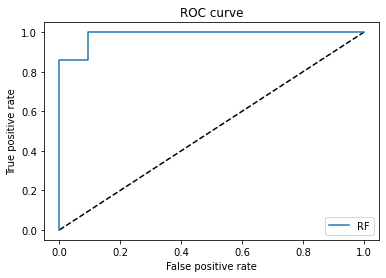

In [251]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.00      0.00      0.00         2

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

Confusion Matrix
[[6 0]
 [2 0]]

Accuracy
0.75


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


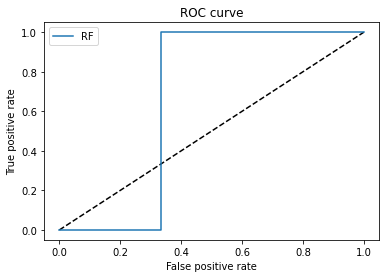

In [252]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### End of Notebook